# Reflection Ablation Analysis (True vs False)

## Experiment Plan
- **Goal**: Evaluate the impact of `use_reflection` on task `04_titanic`.
- **Controlled design**:
  - Group A: `use_reflection=True` (3 runs)
  - Group B: `use_reflection=False` (3 runs)
- **Fixed conditions**: same task, same data path, same repository, and same evaluation workflow.
- **Metrics**:
  1. Success rate
  2. Per-run duration (`duration_seconds`)
  3. Mean ± standard deviation of duration
- **Outputs**: master table, summary table, comparison figure, and report-ready conclusion snippet.

In [2]:
from pathlib import Path
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BASE_DIR = Path('/Users/tian/CUHK/FTEC-5660/project/MetaGPT')
BENCH_DIR = BASE_DIR / 'benchmark_results'
OUT_DIR = BENCH_DIR / 'ablation_summary'
OUT_DIR.mkdir(parents=True, exist_ok=True)

print(f'Benchmark dir: {BENCH_DIR}')
print(f'Output dir: {OUT_DIR}')

Benchmark dir: /Users/tian/CUHK/FTEC-5660/project/MetaGPT/benchmark_results
Output dir: /Users/tian/CUHK/FTEC-5660/project/MetaGPT/benchmark_results/ablation_summary


In [9]:
def parse_use_reflection(report_path: Path):
    if not report_path.exists():
        return None
    text = report_path.read_text(encoding='utf-8', errors='ignore')
    m = re.search(r'\*\*Use Reflection:\*\*\s*(True|False)', text)
    if not m:
        return None
    return True if m.group(1) == 'True' else False

rows = []
for run_dir in sorted(BENCH_DIR.glob('run_*')):
    results_json = run_dir / 'results.json'
    report_md = run_dir / 'report.md'
    if not results_json.exists():
        continue

    use_reflection = parse_use_reflection(report_md)
    payload = json.loads(results_json.read_text(encoding='utf-8'))

    for item in payload.get('results', []):
        rows.append({
            'run_dir': run_dir.name,
            'use_reflection': use_reflection,
            'task_name': item.get('task_name'),
            'status': item.get('status'),
            'duration_seconds': item.get('duration_seconds'),
            'timestamp': item.get('timestamp'),
            'error': item.get('error'),
        })

df = pd.DataFrame(rows)
if df.empty:
    raise ValueError('No benchmark results found under benchmark_results/run_*/results.json')

print('Loaded rows:', len(df))
print(df[['run_dir', 'use_reflection', 'task_name', 'status', 'duration_seconds']].to_string(index=False))

Loaded rows: 6
            run_dir  use_reflection  task_name  status  duration_seconds
run_20260301_151116            True 04_titanic success         84.397758
run_20260301_155403            True 04_titanic success        149.645840
run_20260301_155713            True 04_titanic success         67.265624
run_20260301_155901           False 04_titanic success        167.249096
run_20260301_160224           False 04_titanic success        131.873102
run_20260301_160459           False 04_titanic success         56.718754


In [4]:
# Save master table (one row per run result)
master_path = OUT_DIR / 'ablation_master_table.csv'
df.to_csv(master_path, index=False)
print(f'Saved: {master_path}')

df.head()

Saved: /Users/tian/CUHK/FTEC-5660/project/MetaGPT/benchmark_results/ablation_summary/ablation_master_table.csv


,run_dir,use_reflection,task_name,status,duration_seconds,timestamp,error
0,run_20260301_151116,True,04_titanic,success,84.397758,2026-03-01T15:14:52.944313,None
1,run_20260301_155403,True,04_titanic,success,149.645840,2026-03-01T15:56:32.861090,None
2,run_20260301_155713,True,04_titanic,success,67.265624,2026-03-01T15:58:20.728571,None
3,run_20260301_155901,False,04_titanic,success,167.249096,2026-03-01T16:01:49.036718,None
4,run_20260301_160224,False,04_titanic,success,131.873102,2026-03-01T16:04:36.755627,None


In [5]:
# Group-level statistics (True vs False)
summary = (
    df.groupby('use_reflection', dropna=False)
      .agg(
          n_runs=('status', 'count'),
          n_success=('status', lambda s: (s == 'success').sum()),
          success_rate=('status', lambda s: (s == 'success').mean()),
          duration_mean=('duration_seconds', 'mean'),
          duration_std=('duration_seconds', 'std'),
          duration_min=('duration_seconds', 'min'),
          duration_max=('duration_seconds', 'max'),
      )
      .reset_index()
      .sort_values('use_reflection', ascending=False)
)

summary_path = OUT_DIR / 'ablation_summary_table.csv'
summary.to_csv(summary_path, index=False)

print(f'Saved: {summary_path}')
summary

Saved: /Users/tian/CUHK/FTEC-5660/project/MetaGPT/benchmark_results/ablation_summary/ablation_summary_table.csv


,use_reflection,n_runs,n_success,success_rate,duration_mean,duration_std,duration_min,duration_max
1,True,3,3,1.0,100.436407,43.468997,67.265624,149.645840
0,False,3,3,1.0,118.613651,56.445539,56.718754,167.249096


Saved: /Users/tian/CUHK/FTEC-5660/project/MetaGPT/benchmark_results/ablation_summary/ablation_comparison.png


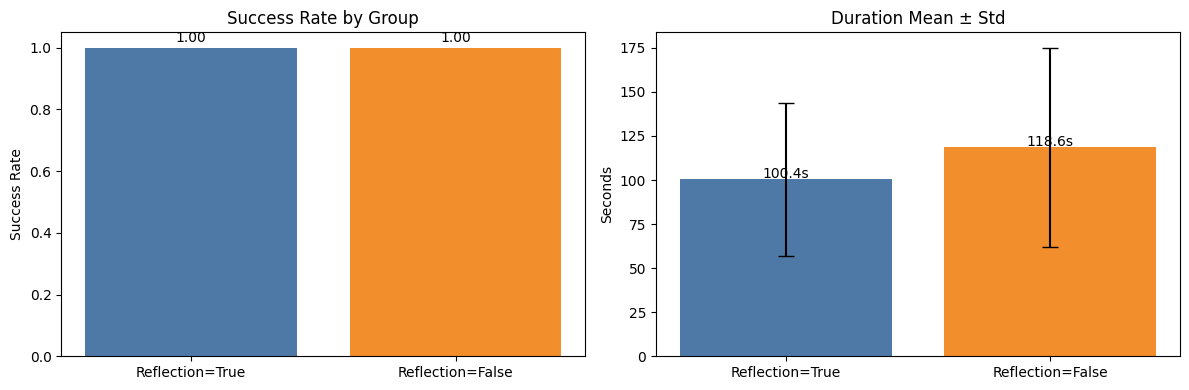

In [6]:
# Visualization: success rate + duration comparison
plot_df = summary.copy()
plot_df['group'] = plot_df['use_reflection'].map({True: 'Reflection=True', False: 'Reflection=False'}).fillna('Unknown')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Success rate
axes[0].bar(plot_df['group'], plot_df['success_rate'], color=['#4e79a7', '#f28e2b'][:len(plot_df)])
axes[0].set_title('Success Rate by Group')
axes[0].set_ylim(0, 1.05)
axes[0].set_ylabel('Success Rate')
for i, val in enumerate(plot_df['success_rate']):
    axes[0].text(i, val + 0.02, f'{val:.2f}', ha='center')

# Duration mean ± std
x = np.arange(len(plot_df))
axes[1].bar(x, plot_df['duration_mean'], yerr=plot_df['duration_std'].fillna(0), capsize=6, color=['#4e79a7', '#f28e2b'][:len(plot_df)])
axes[1].set_xticks(x)
axes[1].set_xticklabels(plot_df['group'])
axes[1].set_title('Duration Mean ± Std')
axes[1].set_ylabel('Seconds')
for i, val in enumerate(plot_df['duration_mean']):
    axes[1].text(i, val + 0.8, f'{val:.1f}s', ha='center')

plt.tight_layout()
fig_path = OUT_DIR / 'ablation_comparison.png'
plt.savefig(fig_path, dpi=200, bbox_inches='tight')
print(f'Saved: {fig_path}')
plt.show()

In [7]:
# Effect summary for report (duration delta)
true_mean = summary.loc[summary['use_reflection'] == True, 'duration_mean']
false_mean = summary.loc[summary['use_reflection'] == False, 'duration_mean']

if len(true_mean) and len(false_mean):
    delta = float(true_mean.iloc[0] - false_mean.iloc[0])
    faster = 'Reflection=False' if delta > 0 else 'Reflection=True'
    print(f'Mean duration delta (True - False): {delta:.2f} seconds')
    print(f'Faster group by mean duration: {faster}')
else:
    print('Cannot compute delta: missing one group.')

Mean duration delta (True - False): -18.18 seconds
Faster group by mean duration: Reflection=True


In [8]:
# Export a ready-to-paste markdown snippet for your project report
row_true = summary[summary['use_reflection'] == True].iloc[0] if (summary['use_reflection'] == True).any() else None
row_false = summary[summary['use_reflection'] == False].iloc[0] if (summary['use_reflection'] == False).any() else None

def fmt_row(name, row):
    if row is None:
        return f'| {name} | - | - | - | - |'
    return f"| {name} | {int(row['n_runs'])} | {row['success_rate']:.2%} | {row['duration_mean']:.2f} | {0.0 if pd.isna(row['duration_std']) else row['duration_std']:.2f} |"

md = []
md.append('## Ablation: `use_reflection` (04_titanic)')
md.append('')
md.append('| Group | Runs | Success Rate | Mean Duration (s) | Std Duration (s) |')
md.append('|---|---:|---:|---:|---:|')
md.append(fmt_row('Reflection=True', row_true))
md.append(fmt_row('Reflection=False', row_false))

if row_true is not None and row_false is not None:
    delta = row_true['duration_mean'] - row_false['duration_mean']
    md.append('')
    md.append(f"- Duration delta (True - False): **{delta:.2f}s**")
    md.append('- Note: Official benchmark number is not explicitly reported for this subset; this is a controlled internal comparison.')

md_text = '\n'.join(md)
print(md_text)

md_path = OUT_DIR / 'ablation_report_snippet.md'
md_path.write_text(md_text, encoding='utf-8')
print(f'\nSaved: {md_path}')

## Ablation: `use_reflection` (04_titanic)

| Group | Runs | Success Rate | Mean Duration (s) | Std Duration (s) |
|---|---:|---:|---:|---:|
| Reflection=True | 3 | 100.00% | 100.44 | 43.47 |
| Reflection=False | 3 | 100.00% | 118.61 | 56.45 |

- Duration delta (True - False): **-18.18s**
- Note: Official benchmark number is not explicitly reported for this subset; this is a controlled internal comparison.

Saved: /Users/tian/CUHK/FTEC-5660/project/MetaGPT/benchmark_results/ablation_summary/ablation_report_snippet.md
